In [ ]:
!pip install wfdb
!pip install py-ecg-detectors
!pip install BaselineRemoval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43817 sha256=4fe96557007a83ec0747e8ceebd9d4916163a42931b2cd97dd65f39c8952ea33
  Stored in directory: /root/.cache/pip/wheels/bb/49/5c/82f92e0ba9a437102b891c68367490fe9fca79df9075059e4e
Successfully built gatspy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import scipy as sci
from scipy import signal
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import wfdb #library for reading ecg data https://github.com/MIT-LCP/wfdb-python/blob/main/demo.ipynb
from ecgdetectors import Detectors # desde https://pypi.org/project/py-ecg-detectors/
from hrv import HRV
from BaselineRemoval import BaselineRemoval

Mounted at /content/drive


# Seccion 1: Cargando los datos



In [ ]:
kaggle_data = pd.read_csv("/content/drive/Shareddrives/Proyecto Final/Progra/databases/kaggle/mitbih_train.csv", delimiter = ",")
PTB_DII = record = wfdb.rdrecord(r'/content/drive/Shareddrives/Proyecto Final/Progra/databases/PTB diagnostic database/Patient 104(HEALTHY)/s0306lre',  channels = [1], sampto = 100000) #con rdrecord lees TODO, con rdsamp lees solo el sampleo que quieres
PTB_data = record = wfdb.rdrecord(r'/content/drive/Shareddrives/Proyecto Final/Progra/databases/PTB diagnostic database/Patient 104(HEALTHY)/s0306lre') #con rdrecord lees TODO, con rdsamp lees solo el sampleo que quieres

PTB tiene 1000 samples por segungdo (frequencia = 1000) por lo cual hay que tomarlo en cuenta al samplear los datos.

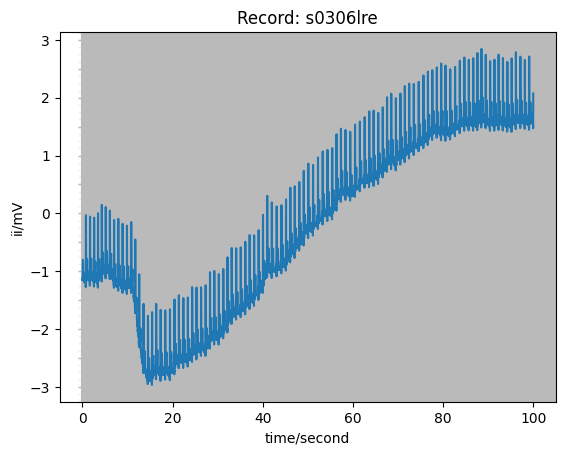

{'record_name': 's0306lre',
 'n_sig': 15,
 'fs': 1000,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 115200,
 'base_time': None,
 'base_date': None,
 'comments': ['age: 58',
  'sex: male',
  'ECG date: 13/07/1992',
  'Diagnose:',
  'Reason for admission: Healthy control',
  'Acute infarction (localization): no',
  'Former infarction (localization): no',
  'Additional diagnoses: no',
  'Smoker: unknown',
  'Number of coronary vessels involved: unknown',
  'Infarction date (acute): n/a',
  'Previous infarction (1) date: n/a',
  'Previous infarction (2) date: n/a',
  'Hemodynamics:',
  'Catheterization date: n/a',
  'Ventriculography: n/a',
  'Chest X-ray: n/a',
  'Peripheral blood Pressure (syst/diast): n/a',
  'Pulmonary artery pressure (at rest) (syst/diast): n/a',
  'Pulmonary artery pressure (at rest) (mean): n/a',
  'Pulmonary capillary wedge pressure (at rest): n/a',
  'Cardiac output (at rest): n/a',
  'Cardiac index (at rest): n/a',
  'Stroke volume index (at rest): n

In [ ]:
wfdb.plot_wfdb(record = PTB_DII , ecg_grids = [0]) #Aqui ploteamos la derivacion 2
display(PTB_data.__dict__)


In [ ]:
ecg_df = PTB_data.to_dataframe() # nos arroja el record como un dataframe que podemos editar, visualizar,y demas
ecg_df

,i,ii,iii,avr,avl,avf,v1,v2,v3,v4,v5,v6,vx,vy,vz
0 days 00:00:00,0.0310,-1.1485,-1.1795,0.5585,0.6055,-1.1640,0.1660,0.2580,0.5730,0.1290,-0.3825,0.0120,-0.3415,-0.6980,0.0095
0 days 00:00:00.001000,0.0290,-1.1485,-1.1775,0.5595,0.6035,-1.1630,0.1675,0.2585,0.5735,0.1280,-0.3835,0.0140,-0.3380,-0.6985,0.0095
0 days 00:00:00.002000,0.0300,-1.1450,-1.1750,0.5570,0.6030,-1.1595,0.1655,0.2585,0.5760,0.1290,-0.3810,0.0150,-0.3370,-0.6960,0.0065
0 days 00:00:00.003000,0.0275,-1.1475,-1.1750,0.5595,0.6015,-1.1610,0.1620,0.2590,0.5760,0.1280,-0.3820,0.0160,-0.3360,-0.6940,0.0075
0 days 00:00:00.004000,0.0295,-1.1490,-1.1785,0.5595,0.6045,-1.1635,0.1620,0.2575,0.5770,0.1275,-0.3820,0.0155,-0.3355,-0.6925,0.0085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:01:55.195000,-0.0870,2.8860,2.9730,-1.4000,-1.5295,2.9295,-1.3035,-1.8070,-2.3495,-1.1215,1.0160,-0.2615,0.3925,2.0100,0.8070
0 days 00:01:55.196000,-0.0995,2.8145,2.9135,-1.3580,-1.5065,2.8640,-1.2630,-1.7480,-2.2910,-1.1085,0.9445,-0.3130,0.3495,1.9635,0.7905
0 days 00:01:55.197000,-0.1165,2.7235,2.8400,-1.3040,-1.4780,2.7815,-1.2210,-1.6845,-2.2310,-1.0950,0.8810,-0.3605,0.3025,1.9015,0.7715
0 days 00:01:55.198000,-0.1115,2.6560,2.7675,-1.2725,-1.4395,2.7120,-1.1765,-1.6185,-2.1695,-1.0800,0.8190,-0.4075,0.2655,1.8340,0.7445


In [ ]:
100*1000

100000

# Seccion 2: Filtrado

In [ ]:
#Filtrado pasa banda de 5 a 15 hz
sos = signal.butter(5, 15, 'hp', fs=1000, output='sos')
filtered_df = pd.DataFrame(signal.sosfilt(sos, ecg_df), columns = ecg_df.columns.to_list())
base_Obj = BaselineRemoval(filtered_df['ii'])
b_rem_df=base_Obj.ZhangFit()

<function matplotlib.pyplot.show(close=None, block=None)>

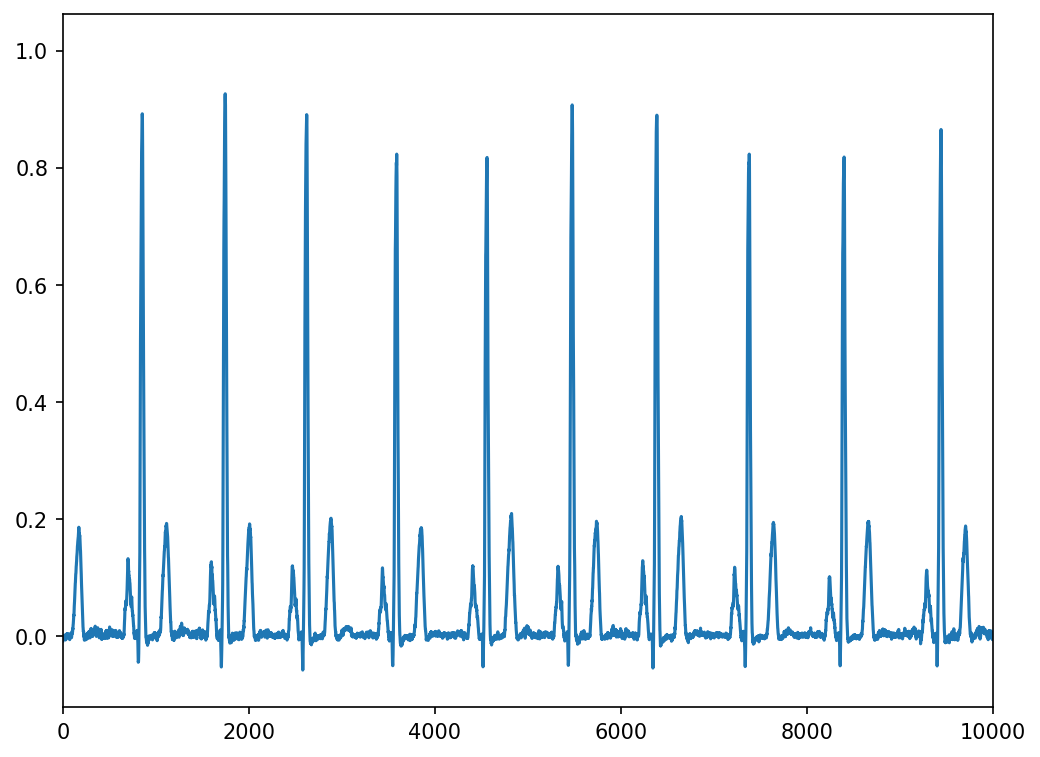

In [ ]:
x = list(range(0, len(filtered_df.index)))


plt.figure(figsize=(8, 6), dpi=150)  # 300 es demasiado y se amontona
ax = plt.axes()

plt.plot(x, b_rem_df)
# plt.plot(x, ecg_df['ii'])

ax.set_xlim([0, 10000])
plt.show

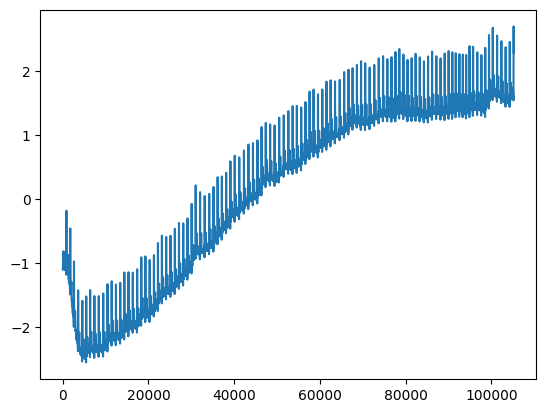

In [ ]:
plt.plot(x, filtered_df['ii'])

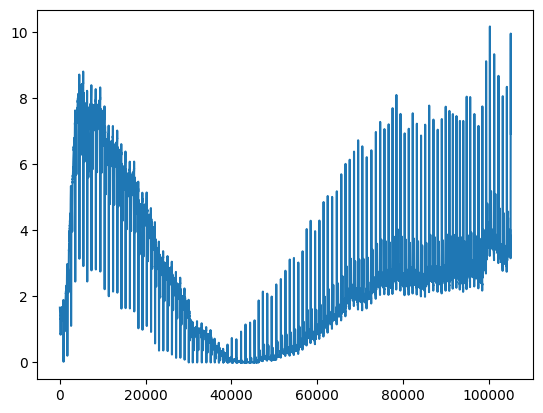

In [ ]:
ecg_sq = ecg_df.pow(2)
plt.plot(x,ecg_sq['ii'])

Bitacora espacial: recorde que en el drive habia incluido una libreria que ya te detectaba picos r y cosas asi, a continuacion muestro como funciona.

In [ ]:
detectors = Detectors(1000)

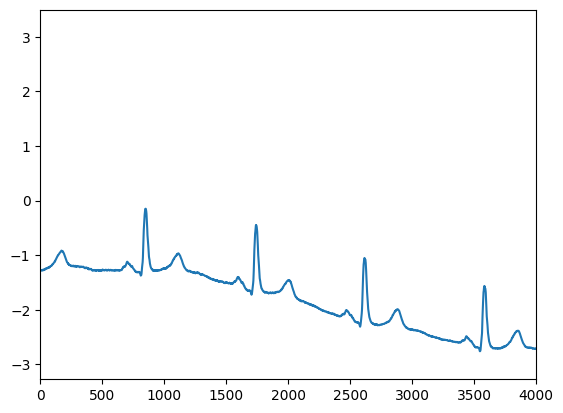

In [ ]:
r_peaks = detectors.pan_tompkins_detector(ecg_df)

# plt.figure(figsize=(8, 6), dpi=150)  # 300 es demasiado y se amontona
ax = plt.axes()

# plt.plot(x, filtered_df['ii'])
plt.plot(x,ecg_df['ii'])


# for item in r_peaks2:
#   plt.axvline(x = item, color = 'r', label = 'axvline - full height')

ax.set_xlim([0,4000])
# ax.set_ylim([-1.2, -1])
plt.show()

<Axes: >

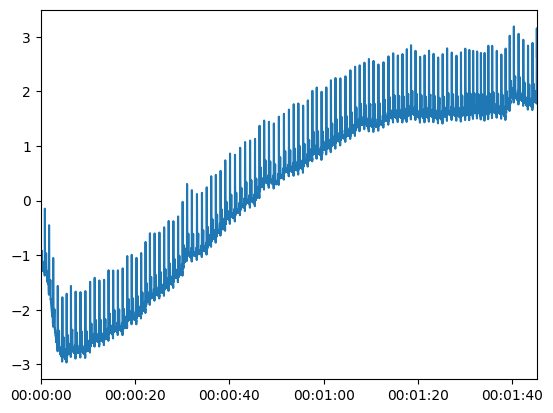

In [ ]:
ecg_df['ii'].plot()

In [ ]:
r_peaks

[302,
 603,
 904,
 1205,
 1506,
 1807,
 2108,
 2409,
 2710,
 3011,
 3312,
 3613,
 3914,
 4215,
 4516,
 4817,
 5118,
 5419,
 5720,
 6021,
 6322,
 6623,
 6931,
 7239,
 7547,
 7855,
 8163,
 8471,
 8779,
 9087,
 9401,
 9653,
 10200,
 10501,
 10809,
 11117,
 11418,
 11719,
 11983,
 14176,
 14484,
 14785,
 15086,
 15387,
 15646,
 16738,
 17045,
 17353,
 17657,
 17963,
 18271,
 18579,
 18887,
 19195,
 19503,
 19811,
 20119,
 20427,
 20735,
 21043,
 21351,
 21659,
 21967,
 22281,
 22583,
 22891,
 23196,
 23499,
 23801,
 24103,
 24404,
 25095,
 25347,
 25655,
 25959,
 26265,
 26573,
 26881,
 27182,
 27483,
 27784,
 28085,
 28386,
 28687,
 28995,
 29303,
 29611,
 29919,
 30227,
 30535,
 30843,
 31148,
 31451,
 31753,
 32058,
 32361,
 32663,
 32971,
 33279,
 33587,
 33895,
 34203,
 34511,
 34819,
 35127,
 35435,
 35740,
 36043,
 36345,
 36648,
 37121,
 37423,
 37731,
 38039,
 38347,
 38655,
 38963,
 39271,
 39579,
 39880,
 40181,
 40482,
 40783,
 41091,
 41399,
 41707,
 42015,
 42323,
 42631,
 42

Para Regina del futuro (o quien lo lea) intente sacar adelante la deteccion de picos R con la libreria, pero no funciono. Hay que revisar hacerlo a mano con https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection/blob/main/Pan_Tompkins.ipynb
Nota de regina del futuro: hay que revisar el indice del ecg_df, tal vez ahi se encuentra el error, habria que corregirlo


# Seccion 3: Obtencion de picos R

In [ ]:
new_ecg_df = b_rem_df
# new_index = pd.Series([x/1000 for x in range(len(ecg_df.index))])
# new_ecg_df = ecg_df.set_index(new_index)

In [ ]:
#intentando los detectores pero ahora con el nuevo y corregido dataframe
# new_ecg_df_np = new_ecg_df.to_numpy()
detectors = Detectors(1000)
r_peaks = {
    
}
r_peaks["Pan Tompkins"] = (detectors.pan_tompkins_detector(new_ecg_df))
r_peaks["Christov"] = (detectors.christov_detector(new_ecg_df))
r_peaks["Hamilton"] = (detectors.hamilton_detector(new_ecg_df))
# r_peaks['Engzee'] = detectors.engzee_detector(new_ecg_df_np)
r_peaks["Stationary Wavelet"] = (detectors.swt_detector(new_ecg_df))
r_peaks["Two Moving Average"] = (detectors.two_average_detector(new_ecg_df))
# r_peaks["Matched Filter"] = detectors.matched_filter_detector(new_ecg_df["ii"])
r_peaks["WQRS"] = (detectors.wqrs_detector(new_ecg_df))


Pan Tompkins 108
Pan Tompkins 74
[   682   2665   4562   6431   7381   8401   9444  11418  12412  14409
  16347  17359  19321  20281  22254  24172  25148  26154  27117  28109
  29110  31057  33113  35225  37160  38127  40124  41180  42273  43319
  44378  46431  48382  49423  50490  51560  53636  55631  56633  57587
  59547  60553  62494  63521  64613  66651  68630  70561  71596  72674
  73725  74731  75723  77666  78515  79476  80446  82372  83292  84266
  86165  88151  90065  90882  92579  94117  95771  96709  97667  99489
 100325 101330 102330 103331]


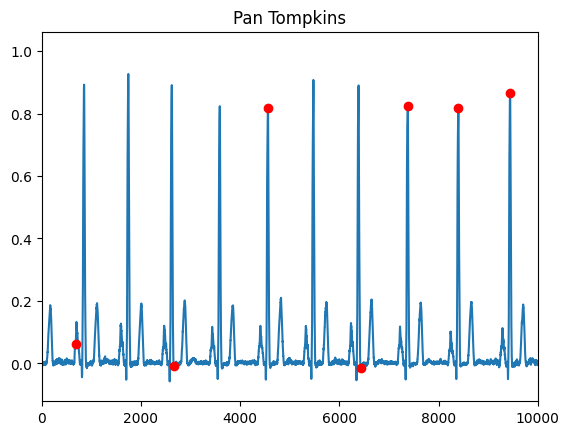

Christov 109
Christov 108
[   757   1746   2622   3590   4562   5469   6378   7369   8389   9431
  10437  11405  12399  13401  14354  15327  16334  17344  18311  19267
  20268  21259  22199  23123  24117  25135  26141  27105  28097  29097
  30061  31003  32023  33099  34159  35169  36121  37105  38114  39099
  40111  41166  42259  43304  44364  45409  46374  47351  48368  49409
  50475  51546  52608  53621  54600  55617  56620  57574  58505  59534
  60540  61515  62481  63508  64599  65641  66637  67611  68616  69577
  70548  71583  72659  73710  74717  75710  76690  77610  78504  79464
  80434  81389  82317  83280  84254  85214  86153  87144  88139  89095
  90012  90872  91682  92526  93331  94109  94900  95719  96699  97656
  98559  99436 100315 101318 102319 103320 104273 105179]


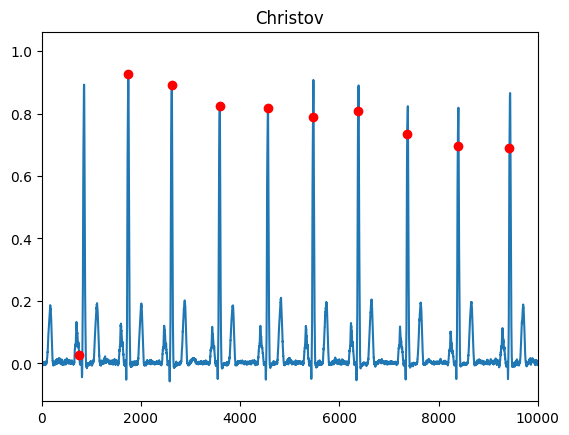

Hamilton 109
Hamilton 54
[   772   2506   4444   6273   8282  10330  12294  14247  16226  18206
  20161  22096  24012  26033  27989  29955  31918  34053  36015  38007
  40004  42154  44257  46269  48262  50370  52503  54495  56513  58398
  60430  62375  64492  66531  68511  70441  72552  74610  76585  78397
  80327  82212  84148  86048  88030  89906  91576  93221  94795  96594
  98453 100208 102214 104166]


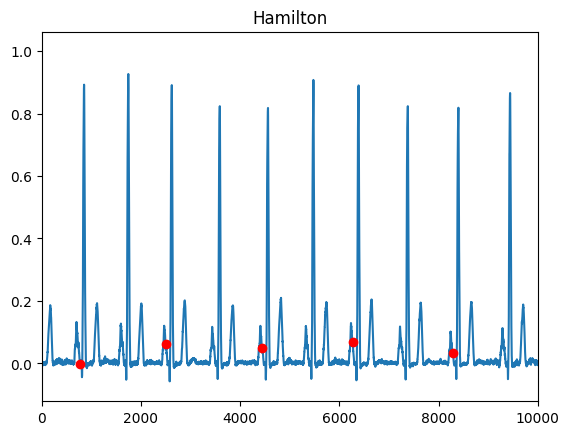

Stationary Wavelet 110
Stationary Wavelet 96
[   607   1703   3570   5448   7361   9399  10436  11403  12397  13394
  14346  15332  16326  17344  18304  19264  21241  23120  25128  26153
  28089  30059  31001  32016  33093  34152  35161  36118  37097  38106
  39092  40104  41160  42253  43298  44357  45403  46373  47344  48362
  49402  50480  51540  52603  53621  54593  55617  56618  57572  58502
  59527  60533  61507  62474  63501  64593  65635  66631  67609  68609
  69576  70541  71582  72659  73705  74716  75702  76689  77602  78495
  79462  80426  81386  82315  83272  84246  85212  86145  88131  89087
  90009  90862  91670  92515  93319  94103  95708  96689  97652  99416
 100307 101323 102310 103317 104270 105176]


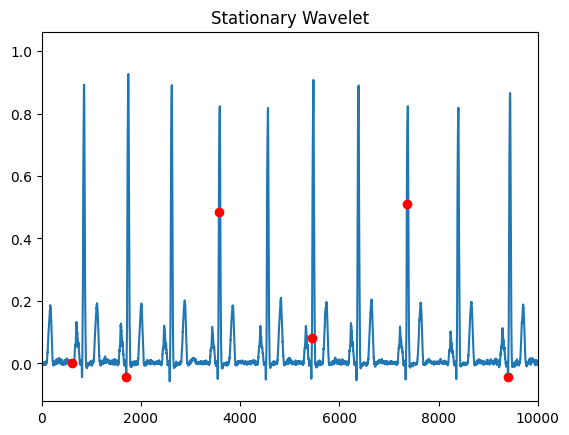

Two Moving Average 108
Two Moving Average 54
[   929   2695   4634   6461   8474  10523  12485  14439  16419  18397
  20353  22284  24202  26227  28181  30147  32108  34245  36206  38199
  40196  42346  44450  46461  48454  50563  52697  54686  56706  58589
  60626  62566  64686  66723  68703  70633  72746  74804  76776  78587
  80519  82402  84339  86238  88224  90096  91762  93412  94983  96781
  98643 100399 102402 104357]


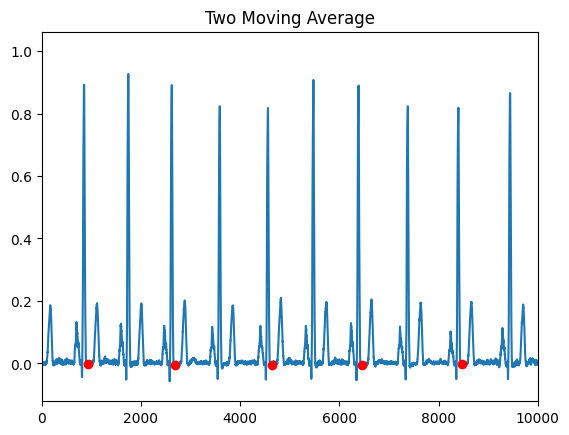

WQRS 196
WQRS 108
[   705   1731   2608   3577   4549   5465   6375   7368   8389   9431
  10437  11405  12400  13402  14352  15328  16334  17347  18311  19265
  20268  21260  22198  23121  24118  25137  26142  27104  28097  29098
  30061  31000  32023  33101  34161  35169  36119  37105  38115  39099
  40111  41167  42260  43305  44365  45410  46373  47350  48369  49410
  50476  51547  52610  53622  54600  55618  56620  57573  58503  59535
  60541  61514  62481  63509  64602  65643  66639  67611  68618  69577
  70548  71584  72661  73712  74718  75710  76691  77609  78502  79463
  80434  81389  82315  83280  84254  85214  86152  87145  88139  89094
  90010  90869  91678  92523  93328  94105  94897  95716  96697  97656
  98558  99434 100313 101318 102319 103321 104271 105176]


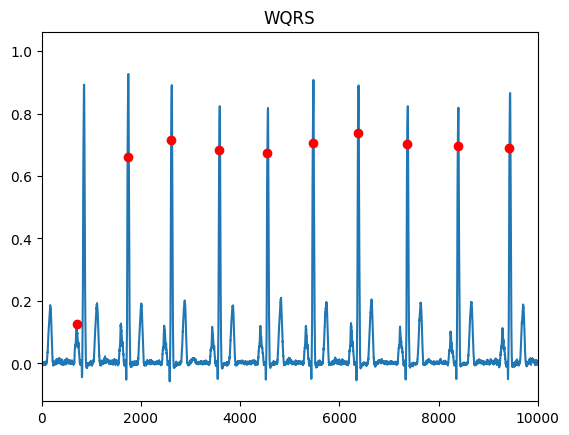

In [ ]:

for method in r_peaks:
  print(method, len(r_peaks[method]))
  #METODO PARA LIMPIAR MENORES A 0.2
  for i in range(len(r_peaks[method])):
    try:
      if new_ecg_df[r_peaks[method][i]] < 0.2:
        r_peaks[method].pop(i)
    except:
      break
  print(method, len(r_peaks[method]))
  data = np.asarray(r_peaks[method])
  print(data)
  plt.figure()
  ax = plt.axes()
  plt.plot(x, new_ecg_df)
  plt.plot(data, new_ecg_df[data], 'ro')
  ax.set_xlim([0,10000])
  plt.title(method)
  plt.show()

Articulo que salvo mi VIDA: https://dsp.stackexchange.com/questions/58155/how-to-filter-ecg-and-detect-r-peaks Special thanks a chat gpt por encontrar errores en mi codigo 🙏

21/04/2022
Mejor para encontrar picos R: wqrs
Mejor para encontrar S : Two moving average

# Seccion 4: Obtencion de Heart rate y otras cosas


In [ ]:
hrv_class = HRV(1000)
heart_rate = HRV.HR(hrv_class, r_peaks["WQRS"])
# heart_rate = heart_rate.mean()
print(heart_rate)

[58.47953216 68.41505131 61.91950464 61.72839506 65.50218341 65.93406593
 60.42296073 58.76591577 57.5815739  59.64214712 61.98347107 60.30150754
 59.88023952 63.15789474 61.47540984 59.64214712 59.23000987 62.2406639
 62.89308176 59.82053838 60.48387097 63.96588486 65.00541712 60.18054162
 58.88125613 59.70149254 62.37006237 60.42296073 59.94005994 62.30529595
 63.89776358 58.65102639 55.65862709 56.60377358 59.52380952 63.15789474
 60.85192698 59.40594059 60.97560976 59.28853755 56.81818182 54.894785
 57.41626794 56.60377358 57.41626794 62.30529595 61.41248721 58.88125613
 57.63688761 56.28517824 56.02240896 56.44402634 59.28853755 61.34969325
 58.93909627 59.88023952 62.9590766  64.51612903 58.13953488 59.64214712
 61.66495375 62.0475698  58.36575875 54.894785   57.63688761 60.24096386
 61.72839506 59.58291956 62.56517205 61.79196704 57.91505792 55.71030641
 57.08848716 59.64214712 60.48387097 61.16207951 65.35947712 67.18924972
 62.43496358 61.79196704 62.82722513 64.79481641 62.17

Parece ser que la funcion de heart rate te regresa el valor de los heart beats dependiendo de cuantos picos R lee, al principio es 78, pero se va a cercando a 60 a medida que pasa el tiempo.

Bitacora espacial: Me di cuenta que mientras mas datos, mas baseline drift hay en ellos. Asi que instale la libreria de BaselineRemoval, utilizando ZhangFit, con eso parecio funcionar.
Haciendo un filtro de r_peaks menores a 0.2, podemos obtener mejores resultados de r_peaks.

Los siguientes son datos del modulo de ecg_detectors, que podemos utilizar para valuar el modelo de machine learning y encontrar correlaciones.

In [ ]:
nn20 = HRV.NN20(hrv_class,r_peaks['WQRS']) #the number of pairs of successive NNs that differ by more than 20 ms.
nn50 = HRV.NN50(hrv_class,r_peaks['WQRS']) # the number of pairs of successive NNs that differ by more than 50 ms.
pnn20 = HRV.pNN20(hrv_class,r_peaks['WQRS']) # the proportion of NN20 divided by total number of NNs.
pnn50 = HRV.pNN50(hrv_class,r_peaks['WQRS']) # the proportion of NN50 divided by total number of NNs.
rmssd = HRV.RMSSD(hrv_class,r_peaks['WQRS']) # (root mean square of successive differences).
# sdann = HRV.SDANN(hrv_class,r_peaks['WQRS']) # the standard deviation of the average RR intervals calculated over short periods.
sdnn = HRV.SDNN(hrv_class,r_peaks['WQRS']) # the standard deviation of NN intervals.
sdsd = HRV.SDSD(hrv_class,r_peaks['WQRS']) # Calculate SDSD (standard deviation of successive differences), the standard deviation of the successive differences between adjacent NNs.

In [ ]:
print(nn20, nn50, pnn20, pnn50, rmssd, sdnn, sdsd)

77 26 0.719626168224299 0.24299065420560748 46.762648374731995 63.21989402424448 46.74871377087288


In [ ]:
if heart_rate > 100 :
  HR_state = "tachycardia"
elif heart_rate < 60:
  HR_state = "bradycardia"
else:
  HR_state = "normal"
print(HR_state)

ValueError: ignored